# Gaussian Process and Machine Learning

In [1]:
using ColorSchemes
using Optim
using Plots
using Printf
using Statistics
using LaTeXStrings

In [2]:
include("gp.jl")

gpr (generic function with 1 method)

## Sampling from 1D Gaussian Process

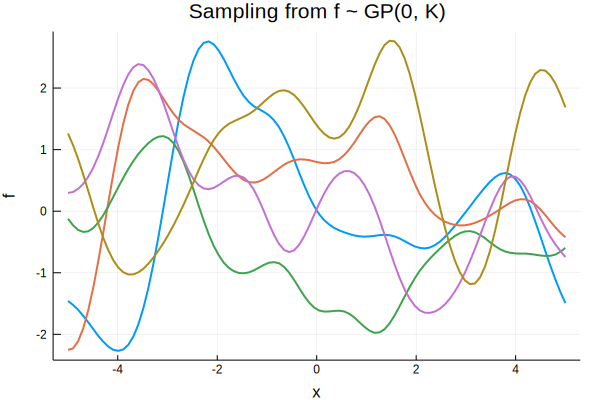

In [3]:
xs = collect(range(-5, stop = 5, length = 100))

gp = GaussianProcess(GaussianKernel(1, 1))
Plots.plot(xs, rand(dist(gp, xs), 5), 
    label = "", xlabel = "x", ylabel = "f",
    linewidth = 2,
    title = "Sampling from f ~ GP(0, K)")

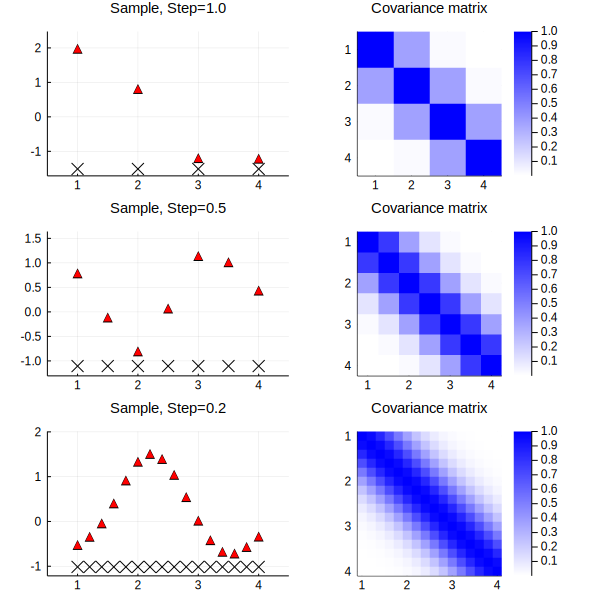

In [4]:
xx = [1:4, 1:0.5:4, 1:0.2:4]
yy = [1, 0.5, 0.2]

plts = []
for (x, y) in zip(xx, yy)
    x1 = collect(x)
    n = Base.length(x)
    sample = rand(dist(gp, x1))
    sample_min = minimum(sample)
    sample_plot = scatter(x, sample, label = "",
            markershape = :utriangle, markercolor = :red,
            title = @sprintf("Sample, Step=%.1f", y), titlefontsize = 10)
    scatter!(x, fill(sample_min - 0.3, n),
        xlims = (0.5, 4.5),
        ylims = (sample_min - 0.5, maximum(sample) + 0.5),
        markershape = :x, markerstrokewidth = 2,
        label = "")
    push!(plts, sample_plot)
    push!(plts, heatmap(x1, x1, cov(gp, x1), 
            title = "Covariance matrix", titlefontsize = 10,
            aspect_ratio = :equal, yflip = true, color = cgrad([:white, :blue])))
end

Plots.plot(plts..., layout = (3, 2), size = [600, 600])

## Sampling from 2D Gaussian Process

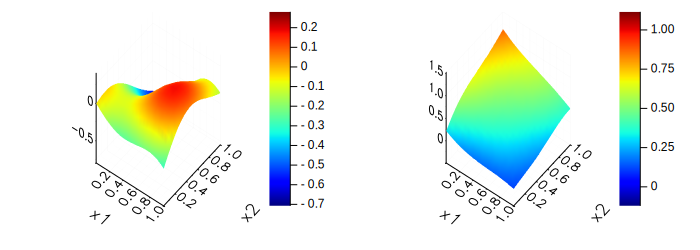

In [5]:
x1, x2 = 0:0.05:1, 0:0.05:1
n1, n2 = Base.length(x1), Base.length(x2)
n = n1 * n2
pt = permutedims(hcat([[i, j] for i in x1, j in x2]...));
sample = rand(dist(gp, pt), 2)

plts = []
for i in 1:2
    z = reshape(sample[:, i], n1, n2)
    push!(plts,
        surface(x1, x2, z, alpha = 0.8, camera = (40, 60),
        seriescolor = cgrad(ColorSchemes.jet1.colors), 
        linewidth = 2,
        framestyle = :grid,
        xlabel = "x1", ylabel = "x2", zlabel = "f"))
end
Plots.plot(plts..., layout = (1, 2), size = [700, 250])

## Kernel Types (Linear, Gaussian, Exponential, Periodic)

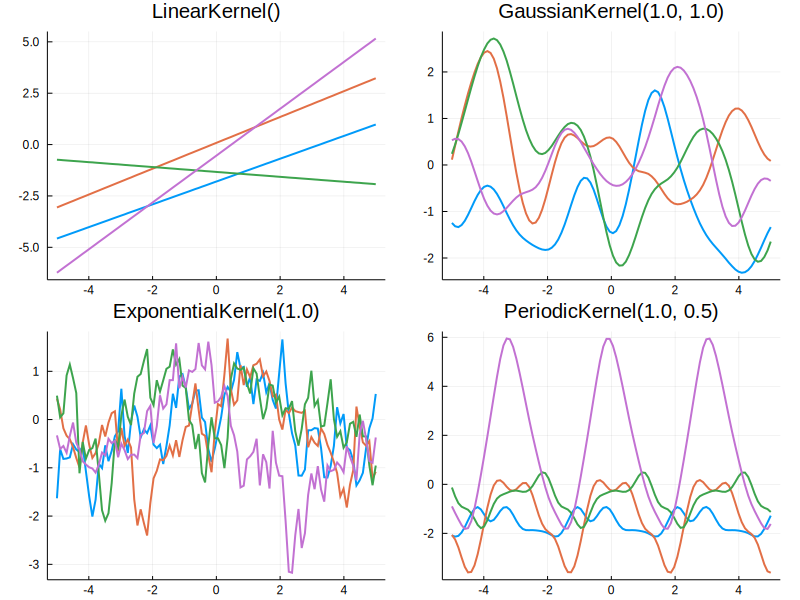

In [6]:
xs = collect(range(-5, stop = 5, length = 100))
kernels = [LinearKernel(), GaussianKernel(1, 1),
           ExponentialKernel(1), PeriodicKernel(1.0, 0.5)]
plts = []

for k in kernels
    gp = GaussianProcess(k)
    p = Plots.plot(xs, rand(dist(gp, xs), 4), label = "", linewidth = 2, title = @sprintf("%s", k))
    push!(plts, p)
end
    
Plots.plot(plts..., layout = (2, 2), size = [800, 600])

## Linear combination

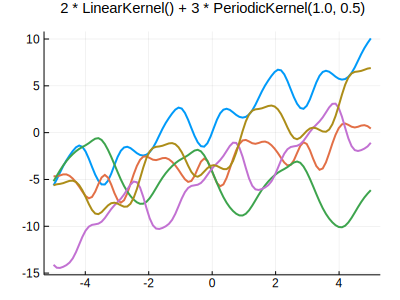

In [7]:
xs = collect(range(-5, stop = 5, length = 100))
l_ker = 2.0 * LinearKernel() + 3.0 * PeriodicKernel(1.0, 0.5)

gp = GaussianProcess(l_ker)
Plots.plot(xs, rand(dist(gp, xs), 5), 
    label = "", size = [400, 300],
    linewidth = 2,
    title = "2 * LinearKernel() + 3 * PeriodicKernel(1.0, 0.5)", titlefontsize = 10)

## Matérn kernel

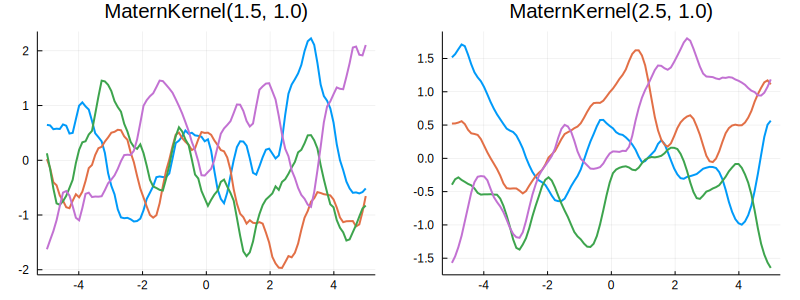

In [8]:
xs = collect(range(-5, stop = 5, length = 100))
kernels = [MaternKernel(3/2, 1.), MaternKernel(5/2, 1.)]
plts = []

for k in kernels
    gp = GaussianProcess(k)
    p = Plots.plot(xs, rand(dist(gp, xs), 4), label = "", linewidth = 2, title = @sprintf("%s", k))
    push!(plts, p)
end
    
Plots.plot(plts..., layout = (1, 2), size = [800, 300])

## Gaussian Process Regression

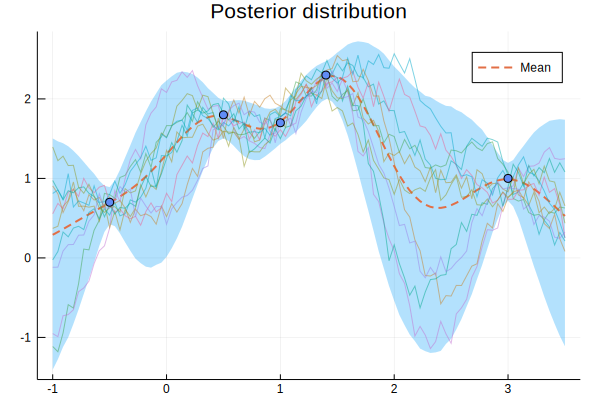

In [9]:
xs = [-0.5, 0.5, 1, 1.4, 3]
ys = [0.7, 1.8, 1.7, 2.3, 1]
gp = GaussianProcess(GaussianKernel(1.0, 0.4), 0.01)
xtrain = collect(range(-1, stop=3.5, length=100))
pred = gpr(gp, xtrain, xs, ys)
qt = mapslices(x -> quantile(x, [0.025, 0.925]), rand(pred, 10000), dims = 2)

Plots.plot(xtrain, qt[:, 1], fillrange = qt[:, 2], fillalpha = 0.3,
    label = "", linewidth = 0)
Plots.plot!(xtrain, mean(pred), label = "Mean", linewidth = 2, linestyle = :dash)
Plots.plot!(xtrain, rand(pred, 10), label = "", linewidth = 1, linealpha = 0.5)

scatter!(xs, ys, label = "", title = "Posterior distribution")

## Hyperparameter optimization with Optim.jl

In [10]:
mutable struct HyperParamHelper1
    gp::GaussianProcess
    xs::Vector{Float64}
    ys::Vector{Float64}
    n_xs::Int64
    distance_matrix::Matrix{Float64}
    k::Matrix{Float64}
    k_inv::Matrix{Float64}
    k_inv_y::Vector{Float64}
end

function HyperParamHelper1(gp::GaussianProcess, xs::Vector{Float64}, ys::Vector{Float64})
    n_xs = Base.length(xs)
    distance_matrix = zeros(n_xs, n_xs)
    for i in 1:n_xs
        for j in 1:n_xs
            distance_matrix[i, j] = (xs[i] - xs[j]).^2
        end
    end
    k = cov(gp, xs)
    k_inv = inv(k)
    k_inv_y = k_inv * ys
    HyperParamHelper1(gp, xs, ys, n_xs, distance_matrix, k, k_inv, k_inv_y)
end

function update!(hp::HyperParamHelper1, params)
    y = exp.(params)
    update!(hp.gp, y...)
    hp.k = cov(hp.gp, hp.xs)
    hp.k_inv = inv(hp.k)
    hp.k_inv_y = hp.k_inv * hp.ys
    hp
end

function logp(hp::HyperParamHelper1)
    - log(det(hp.k)) - hp.ys' * hp.k_inv * hp.ys
end

function deriv(hp::HyperParamHelper1, d_mat)
     -tr(hp.k_inv * d_mat) + hp.k_inv_y' * d_mat * hp.k_inv_y
end

function g!(hp::HyperParamHelper1, G, params)
    y = exp.(params)
    d_tau = hp.k - y[3] .* Matrix{Float64}(I, hp.n_xs, hp.n_xs)
    d_sigma = d_tau ./ y[2] .* hp.distance_matrix
    d_eta = y[3] .* Matrix{Float64}(I, hp.n_xs, hp.n_xs)
    G[1] = deriv(hp, d_tau)
    G[2] = deriv(hp, d_sigma)
    G[3] = deriv(hp, d_eta)
    println(params, G)
    G
end

g! (generic function with 1 method)

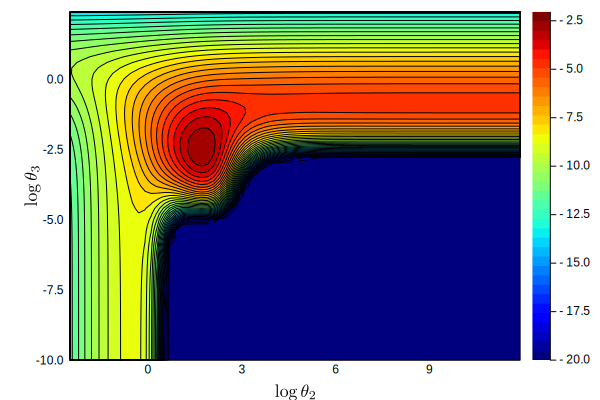

In [11]:
xs = [-0.5, 0.5, 1, 1.4, 3]
ys = [0.7, 1.8, 1.7, 2.3, 1]

hp1 = HyperParamHelper1(GaussianProcess(GaussianKernel(1, 1), 1), xs, ys)

function f_logp(x, y)
    update!(hp1, [0, x, y])
    max(-20, logp(hp1))
end

theta2, theta3 = -2.5:0.2:12, -10:0.2:2.5
z = Surface((x, y) -> f_logp(x, y), theta2, theta3)
contourf(theta2, theta3, z, seriescolor = cgrad(ColorSchemes.jet1.colors), 
    levels = collect(-20:0.5:-2),
    xlabel = L"\log \theta_2", ylabel = L"\log \theta_3",
    guidefont=font(12))

In [12]:
G = zeros(3)
g!(hp1, G, log.([1.59643, 6.5603, 0.0819847]))

[0.46777, 1.88104, -2.50122][-4.11714, 0.098062, -0.0301541]


3-element Array{Float64,1}:
 -4.1171443263227285  
  0.09806198068480683 
 -0.030154070835786542

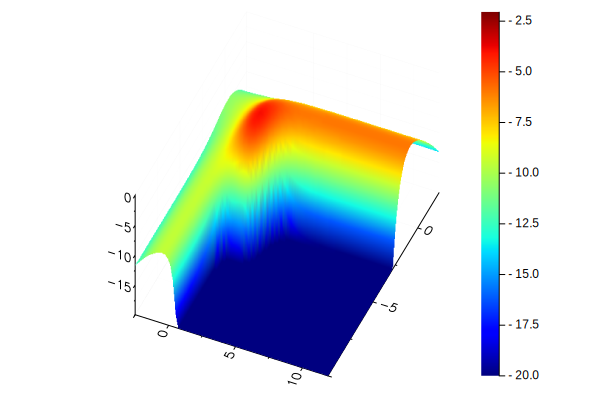

In [13]:
surface(theta2, theta3, z, seriescolor = cgrad(ColorSchemes.jet1.colors), camera = (30, 70))

In [14]:
function f(x)
    update!(hp1, [0, x...])
    -logp(hp1)
end
res = optimize(f, [-5.0, -5.0], [5.0, 5.0], [0.0, 0.0])
pars = Optim.minimizer(res)
print(pars)
logp(hp1)

[1.72862, -2.48319]

-2.0299222400060923

[1.59643, 6.5603, 0.0819847]

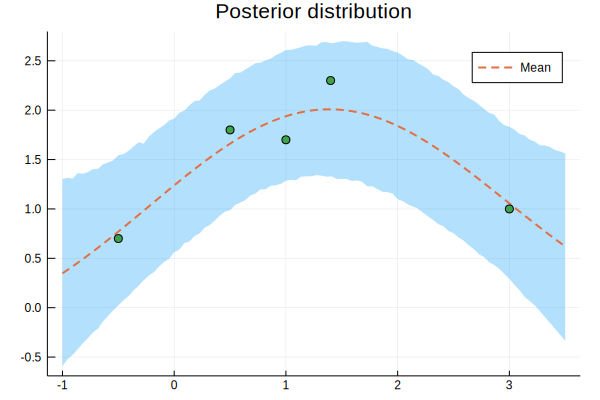

In [15]:
lower = [-5.0, -5.0, -5.0]
upper = [5.0, 5.0, 5.0]
function f(x)
    update!(hp1, x)
    -logp(hp1)
end
res = optimize(f, lower, upper, [0.0, 0.0, 0.0])
pars = Optim.minimizer(res)
print(exp.(pars))

update!(gp, exp.(pars)...)
xtrain = collect(range(-1, stop=3.5, length=100))
pred = gpr(hp1.gp, xtrain, xs, ys)
qt = mapslices(x -> quantile(x, [0.025, 0.975]), rand(pred, 10000), dims = 2)

Plots.plot(xtrain, qt[:, 1], fillrange = qt[:, 2], fillalpha = 0.3,
    label = "", linewidth = 0)
Plots.plot!(xtrain, mean(pred), label = "Mean", linewidth = 2, linestyle = :dash)

scatter!(xs, ys, label = "", title = "Posterior distribution")

In [16]:
# log likelihood
logp(hp1)

-1.738770374339813

In [17]:
res = optimize(
    f,
    (G, x) -> -g!(hp1, G, x),
    lower, upper, [0.0, 0.0, 0.0], Fminbox(LBFGS()))

[0.0, 0.0, 0.0][-8.93147e-8, 8.46936e-8, 1.17731e-7]
[0.0, 0.0, 0.0][-8.93147e-8, 8.46936e-8, 1.17731e-7]
[0.0, 0.0, 0.0][0.58481, 1.07895, -1.47429]
[-0.58481, -1.07895, 1.47429][5.55008, 3.1738, -6.43955]
[-0.292405, -0.539473, 0.737143][-1.3974, 0.0808798, -1.16267]
[-0.146202, -0.269736, 0.368571][-0.242643, 0.377553, -1.08406]
[-0.0731012, -0.134868, 0.184286][0.245229, 0.6747, -1.20761]
[-0.0365506, -0.0674341, 0.0921428][0.437489, 0.864286, -1.32635]
[-0.0182753, -0.033717, 0.0460714][0.517101, 0.968703, -1.39732]
[-0.00913765, -0.0168585, 0.0230357][0.552471, 1.02313, -1.43515]
[-0.00456883, -0.00842926, 0.0115179][0.569022, 1.05087, -1.45456]
[-0.00228441, -0.00421463, 0.00575893][0.577011, 1.06487, -1.46439]
[-0.00114221, -0.00210732, 0.00287946][0.580934, 1.0719, -1.46933]
[-0.000571103, -0.00105366, 0.00143973][0.582878, 1.07542, -1.4718]
[-0.000285552, -0.000526829, 0.000719866][0.583845, 1.07718, -1.47304]
[-0.000142776, -0.000263414, 0.000359933][0.584328, 1.07806, -1.47

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [0.0,0.0,0.0]
 * Minimum: 7.169934e+00
 * Iterations: 1
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 1.47e+00 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 74
 * Gradient Calls: 74

## Add more points

[1.5245, 0.689286, 0.0670132]

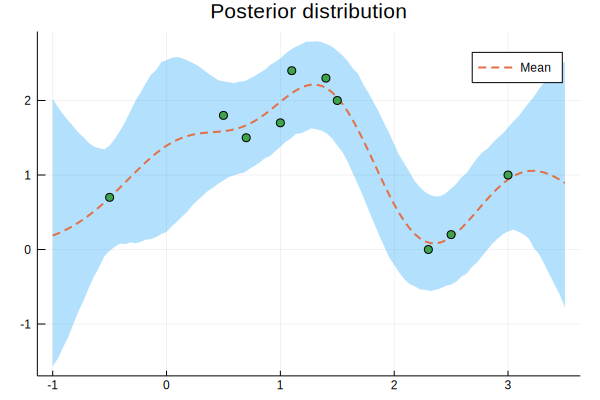

In [18]:
xs = [-0.5, 0.5, 1, 1.4, 3, 2.3, 2.5, 1.5, 1.1, 0.7]
ys = [0.7, 1.8, 1.7, 2.3, 1, 0, 0.2, 2, 2.4, 1.5]

hp2 = HyperParamHelper1(GaussianProcess(GaussianKernel(1, 1), 1), xs, ys)
function f(x)
    update!(hp2, x)
    -logp(hp2)
end

res = optimize(f, lower, upper, [0.0, 0.0, 0.0])
pars = Optim.minimizer(res)
print(exp.(pars))

update!(gp, exp.(pars)...)
xtrain = collect(range(-1, stop=3.5, length=100))
pred = gpr(hp2.gp, xtrain, xs, ys)
qt = mapslices(x -> quantile(x, [0.025, 0.975]), rand(pred, 10000), dims = 2)

Plots.plot(xtrain, qt[:, 1], fillrange = qt[:, 2], fillalpha = 0.3,
    label = "", linewidth = 0)
Plots.plot!(xtrain, mean(pred), label = "Mean", linewidth = 2, linestyle = :dash)

scatter!(xs, ys, label = "", title = "Posterior distribution")

In [19]:
# log likelihood
logp(hp2)

-2.5092991676861978